## An analysis of Reddit comments about HBO’s Euphoria to understand viewers’ experiences and reactions
### Analysis based on posts and comments on the `r/euphoria` subreddit  

#### 3.a Topic Modeling with `BERTopic`

#### SEASON 2

*input*: corpus, embedding model  
*output*: topics, visualization

*tools*:  
`BERTopic`

*about*:  
`BERTopic` is a topic modeling technique that leverages BERT embeddings and a class-based TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.


In [1]:
# %pip install bertopic
# %pip install bertopic[visualization]
# no matches found for bertopic visualization

In [2]:
import pandas as pd
import numpy as np
# going to try modeling with raw comments and cleaned comments
# data_raw = pd.read_pickle('../dat/s2_rue_comments.pkl')
# data_raw = list(data_raw[0])
data_clean = pd.read_pickle('../dat/corpus.pkl')
# data_clean = list(data_clean[0])

In [3]:
from bertopic import BERTopic

Modeling with raw data wasn't ideal. Spam ended up becoming topics.  

---
**Modeling with clean data**

In [8]:
# need to set environment variable to disable token parallelization
# see issue https://github.com/huggingface/transformers/issues/5486
TOKENIZERS_PARALLELISM = True

In [9]:
data_clean2 = data_clean.dropna()

In [ ]:
# model = BERTopicModel(nr_topics=25, id2word=dictionary, passes=10, random_state=2022,
#                       calculate_probability=True, minimum_probability=0.001)
# topics, probabilities= model.fit_transform(list(data_clean2[0]))

In [ ]:
# model.get_topic_freq().head()

In [ ]:
# model.get_topic(0)

[('elliot', 0.05302321466892508),
 ('jule', 0.03420611570571211),
 ('rue', 0.03373225387824607),
 ('be', 0.026852654990114987),
 ('she', 0.026845743070334153),
 ('he', 0.024036766953895016),
 ('and', 0.023875877911608428),
 ('to', 0.02220195014943216),
 ('that', 0.01957623195687411),
 ('with', 0.01955138713236753)]

In [ ]:
# save model
# model.save("../models/bertopic_clean")

In [ ]:
# load model
# model_clean = BERTopic.load('../models/bertopic_clean')

**Visualization**

In [ ]:
model.visualize_topics()

In [ ]:
model.visualize_distribution(probabilities[0])

---

**K-MEANS**

In [10]:
import spacy
nlp = spacy.load('en_core_web_sm')
sw_spacy = nlp.Defaults.stop_words | {'rt', 'via', '…'}
add_stopwords = ['i', 'just','did', 'ab', 'amp', 'ml', 'xb','abc', 'abcb', 'abcny', 'abd', 'abdabca', 'fs', 
                  'zpqxhxhzanapjsjbf', 'zqcsrpwsge', 'zqnuhckwdqwrhkuo', 'zs', 'zshwbhethehenozxfyqg',
                  'zsmkbrmwngzsibrntkt', 'zy', 'zwhnrmujykdxmntiub', 'afqjcnguytghbsuvixmglpwzqbg', 'ebecadcbdfcbafbdb',
                  'abfbmltmqspf', 'abfafebfbad', 'episode', 'season', 's', 'lol']
 
# using spacy stopwords instead of sklearn
stop_words = sw_spacy.union(add_stopwords)

In [17]:
# redoing with kmeans
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(ngram_range=(1, 2),stop_words=stop_words)
from sklearn.cluster import KMeans

cluster_model = KMeans(n_clusters=25, random_state=2022)
topic_model = BERTopic(hdbscan_model=cluster_model,verbose=True,diversity=1,top_n_words=10, 
                       embedding_model="all-MiniLM-L6-v2", nr_topics=25,
                       vectorizer_model=vectorizer_model,calculate_probabilities=True)
topics, probabilities = topic_model.fit_transform(list(data_clean2[0]))

Batches: 100%|██████████| 595/595 [03:18<00:00,  3.00it/s]
2022-08-11 10:40:43,415 - BERTopic - Transformed documents to Embeddings
2022-08-11 10:40:53,115 - BERTopic - Reduced dimensionality
2022-08-11 10:40:53,972 - BERTopic - Clustered reduced embeddings
2022-08-11 10:40:58,203 - BERTopic - Reduced number of topics from 25 to 25


In [18]:
topic_model.get_topic_freq().head()

Topic  Count
0      8   1449
1     13   1360
2      7   1277
3     24   1159
4     15   1159

In [19]:
topic_model.visualize_topics()

In [20]:
topic_model.visualize_heatmap(top_n_topics=25)

Reduce dimensionality of embeddings

In [21]:
from umap import UMAP

sentence_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = sentence_model.encode(list(data_clean2[0]), show_progress_bar=False)

reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(list(data_clean2[0]), reduced_embeddings=reduced_embeddings)

Topic hierarchy

In [22]:
topic_model.visualize_hierarchy()

In [23]:
# topic reduction after training
new_topics, new_probs = topic_model.reduce_topics(list(data_clean2[0]), topics, probabilities, nr_topics=7)

2022-08-11 11:07:39,237 - BERTopic - Reduced number of topics from 25 to 7


In [24]:
topic_model.get_topic_info()

Topic  Count                                Name
0      0   4716  0_elliot_relationship_people_thing
1      1   4016               1_cassie_fez_lexi_rue
2      2   2440    2_euphoria_zendaya_thing_opening
3      3   2251              3_people_like_feel_rue
4      4   2055          4_laurie_addict_ali_people
5      5   1843              5_dm_pls_spoiler_agree
6      6   1708        6_people_character_time_good

In [28]:
topic_model.visualize_barchart()

---

SENTIMENT ANALYSIS

In [30]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [31]:
def sentiment_scores(sentence):
# Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
# polarity_scores method of SentimentIntensityAnalyzer
# oject gives a sentiment dictionary.
# which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    # print("Overall sentiment dictionary is : ", sentiment_dict)
    # print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
    # print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
    # print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
    # print("Sentence Overall Rated As", end = " ")
    # decide sentiment as positive, negative and neutral
    # if sentiment_dict['compound'] >= 0.05 :
    #     x = "Positive"
    # elif sentiment_dict['compound'] <= - 0.05 :
    #     x = "Negative"
    # else :
    #     x = "Neutral"
    return sentiment_dict['compound']


<AxesSubplot:>

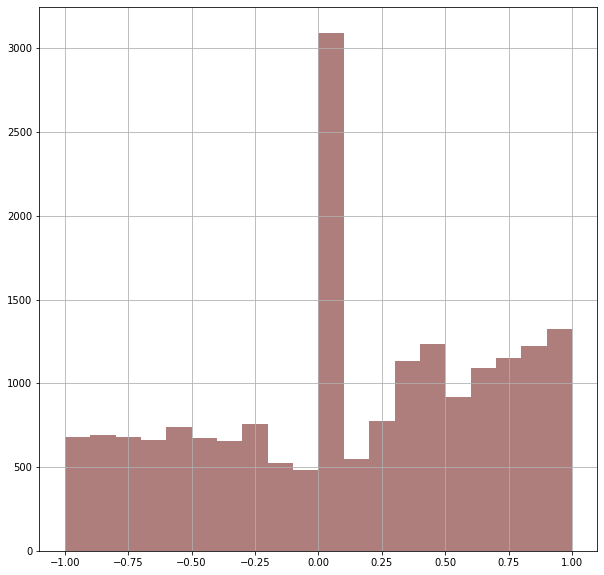

In [32]:

# group data by topic and apply sentiment analysis
data_clean2['topic'] = topics
# group comments by topic
data_clean2['senti'] = data_clean2[0].apply(sentiment_scores)
# plot distribution of sentiment scores
import matplotlib as plt

data_clean2['senti'].hist(bins=20, figsize=(10,10), color='#9A5E5D',
                            linewidth=0, alpha=0.8)


In [33]:
# compute average senti score per topic
sent_per_topic = data_clean2.groupby('topic').mean()
# get overall sentiment
def get_general_sentiment(senti_score):
    if senti_score >= 0.05 :
        x = "Positive"
    elif senti_score <= - 0.05 :
        x = "Negative"
    else :
        x = "Neutral"
    return x

sent_per_topic['sentiment'] = sent_per_topic['senti'].apply(get_general_sentiment)

---

MODEL 2 - ROBERTA  
N = 20

In [ ]:
cluster_model = KMeans(n_clusters=25)
topic_model_r = BERTopic(hdbscan_model=cluster_model,verbose=True,diversity=1,top_n_words=10, 
                       embedding_model="all-distilroberta-v1", nr_topics=20,
                       vectorizer_model=vectorizer_model,calculate_probabilities=True)
topics_r, probabilities_r = topic_model_r.fit_transform(list(data_clean2[0]))


In [ ]:
topic_model_r.get_topic_freq().head()

Topic  Count
0      0   1810
1      1   1622
2      2   1571
3      3   1184
4      4   1165

In [ ]:
topic_model_r.visualize_topics()

In [ ]:
topic_model_r.visualize_hierarchy()

**Topic Reduction**

this model has some topics that are overlapping

In [60]:
# topic reduction after training
new_topics, new_probs = topic_model_r.reduce_topics(list(data_clean2[0]), topics, probabilities, nr_topics=5)

2022-08-11 00:22:04,671 - BERTopic - Reduced number of topics from 20 to 5


In [61]:
topic_model_r.get_topic_info()

Topic  Count                              Name
0      0   4606      0_think_people_euphoria_want
1      1   4570              1_rue_drug_like_lexi
2      2   4462             2_nate_maddy_rue_drug
3      3   2967  3_elliot_think_relationship_feel
4      4   2436         4_thank_leak_people_point

In [62]:
topic_model_r.visualize_barchart()

In [ ]:
embeddings = sentence_model.encode(list(data_clean2[0]), show_progress_bar=False)

reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model_r.visualize_documents(list(data_clean2[0]), reduced_embeddings=reduced_embeddings)

---

In [49]:
# topic representation - BIGRAMS
# topic_model_r.update_topics(list(data_clean2[0]), new_topics, n_gram_range=(1, 3))

In [50]:
# get new topic representation
# topic_model_r.get_topic_freq().head()

Topic  Count
0      0   5241
1      1   4342
2      2   3344
3      3   3147
4      4   2967

Not happy with these results...

---

#### Setiment analyis of topics

In [66]:
# getting valence scores for each topic
# vader library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

ModuleNotFoundError: No module named 'vaderSentiment'

Use a custom CountVectorizer instead:

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer

# cv = CountVectorizer(ngram_range=(1, 3), stop_words="english")
# model.update_topics(list(data_clean2[0]), topics, vectorizer_model=cv)

In [ ]:
# model.get_topic_freq().head()

In [ ]:
# model.get_topic(0)

Try using the 'auto' option for number of topics:

In [ ]:
# automatically reduce topics
# model_auto = BERTopic(calculate_probabilities=True, nr_topics='auto')
# topics_auto, probabilities_auto = model_auto.fit_transform(list(data_clean2[0]))

In [ ]:
# model_auto.get_topic_freq().head()

In [ ]:
# model_auto.get_topic(2)

In [ ]:
# visualize topics
# model_auto.visualize_distribution(probabilities_auto[0])
# bad probabilites

---

**model with raw data**

In [ ]:
# need to set environment variable to disable token parallelization
# see issue https://github.com/huggingface/transformers/issues/5486
# TOKENIZERS_PARALLELISM = True

In [ ]:
# according to fitting error, there is a NaN in the data
# sequence item 57: expected str instance, float found

import numpy as np
# data_raw2 = data_raw.dropna()

In [ ]:
# model = BERTopic(nr_topics=30)
# topics, probabilities = model.fit_transform(list(data_raw2[0]))

In [ ]:
# model.get_topic_freq().head()

-1 refers to all outliers which do not have a topic assigned. Forcing documents in a topic could lead to poor performance. Thus, we ignore Topic -1

In [ ]:
# lets look at topic 0

# model.get_topic(0)

In [ ]:
# save model
# model.save('../models/bertopic_model_raw')

a lot of stop words included so will repeat with clean data (ABOVE)